### Binary classification based on 3 layers neural network
#### author: Kim Jeong Min

##### load images

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torch.autograd import Variable
import random
from random import shuffle

import math
import torch.utils.data as data_utils

from PIL import Image

In [0]:
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return out

In [0]:
class Autoencoder(nn.Module):
    def __init__(self, channels=1):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,16,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,128,3,padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,3,2,1,1),
            nn.Sigmoid()
        )
        
                
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def add_noise(images):
  MEAN = 0
  copyed = np.copy(images)
  for img in copyed:
    sigma = 0.01 * random.randint(1,5)
    gaussian = np.random.normal(MEAN, sigma, (img.shape[0],img.shape[1]))
    img = img + gaussian
  return copyed

In [0]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
drive_prefix = '/content/drive/My Drive/'
train_data_path = drive_prefix + 'train.npy'
train_set = np.load(train_data_path)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
noised = add_noise(train_set)

## train data ##
# make 3d tensor object
train_set = torch.from_numpy(train_set).unsqueeze(1)
noised = torch.from_numpy(noised).unsqueeze(1)

# set feature = noised, target = clean
train_dataset = data_utils.TensorDataset(noised, train_set)
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4)  

## test data ##
test_data_path = drive_prefix + 'test.npy'
test_set = np.load(test_data_path)
test_set = torch.from_numpy(test_set).unsqueeze(1)

test_dataset = data_utils.TensorDataset(test_set, test_set)
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

##### load neural network model

In [0]:
model = Autoencoder()

##### Set the flag for using cuda

In [0]:
bCuda = True
if bCuda:
    model.cuda()

##### optimization algorithm

In [0]:
LR = 0.05
optimizer   = optim.Adam(model.parameters(), lr=LR, weight_decay = 1e-4)
objective   = nn.MSELoss(reduction='sum')

In [0]:
def train():
    # print('train the model at given epoch')
    loss_train          = []
    model.train()
    for idx_batch, (data, target) in enumerate(loader_train):
        if bCuda:
            data, target    = data.cuda(), target.cuda()
            
        data, target    = Variable(data), Variable(target)
        optimizer.zero_grad()
        
        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std}

##### function for testing the model

In [0]:
def test():
    output = []
    for idx_batch, (data, target) in enumerate(loader_test):
        if bCuda:
          data = data.cuda()

        data = Variable(data)
        output.append(model(data))
    res = torch.cat(output, dim=0)
    return res

##### iteration for the epoch

In [11]:
epoch = 1000
loss_train_mean = list()
loss_train_std = list()

for e in range(epoch):
        
    result_train    = train()
    
    result_loss_train_mean = result_train['loss_train_mean']
    result_loss_train_std =  result_train['loss_train_std']

    loss_train_mean.append( result_loss_train_mean)
    loss_train_std.append(  result_loss_train_std)
    
    epoch_str = '[epoch '+ '{:05d}'.format(e+1)+ ']  '
    epoch_str += 'loss: '+ '(training)' + str(round(result_loss_train_mean, 5))
    print(epoch_str)

    if e >= epoch * 9/10 and loss_train_mean[-1] <= min(loss_train_mean) * (0.55 + (e / epoch)/2):
      break
    
    #adaptive learning rate
    for g in optimizer.param_groups:
        g['lr'] = g['lr'] * 0.9968

[epoch 00001]  loss: (training)111.7588
[epoch 00002]  loss: (training)92.64046
[epoch 00003]  loss: (training)79.0911
[epoch 00004]  loss: (training)72.87327
[epoch 00005]  loss: (training)73.31179
[epoch 00006]  loss: (training)71.54223
[epoch 00007]  loss: (training)72.31634
[epoch 00008]  loss: (training)68.31704
[epoch 00009]  loss: (training)75.13878
[epoch 00010]  loss: (training)71.27193
[epoch 00011]  loss: (training)69.01922
[epoch 00012]  loss: (training)75.94787
[epoch 00013]  loss: (training)68.50854
[epoch 00014]  loss: (training)72.71824
[epoch 00015]  loss: (training)77.5873
[epoch 00016]  loss: (training)67.46383
[epoch 00017]  loss: (training)67.62049
[epoch 00018]  loss: (training)66.988
[epoch 00019]  loss: (training)70.91891
[epoch 00020]  loss: (training)66.74684
[epoch 00021]  loss: (training)66.35219
[epoch 00022]  loss: (training)68.00076
[epoch 00023]  loss: (training)67.97578
[epoch 00024]  loss: (training)71.19871
[epoch 00025]  loss: (training)67.4895
[epoc

##### plot result

In [0]:
def print_history_graph(loss_history, loss_train_std):
    #plt.plot(loss_history, color='#ff0000', label='Train Loss')
    plt.errorbar(list(range(len(loss_history))), loss_history, yerr=loss_train_std, ecolor = '#ffcccc', color='#ff0000', label='Train Loss')
    plt.legend(['Train Loss'])
    plt.title('Loss')
    plt.show()

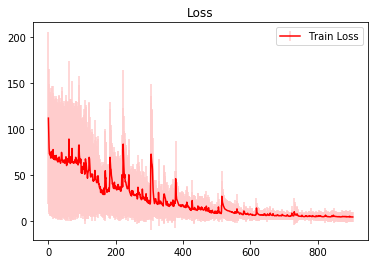

In [13]:
print_history_graph(loss_train_mean, loss_train_std)

In [0]:
result_test = test()

In [0]:
result_img = result_test.squeeze(1)
test_noised = test_set.squeeze(1)

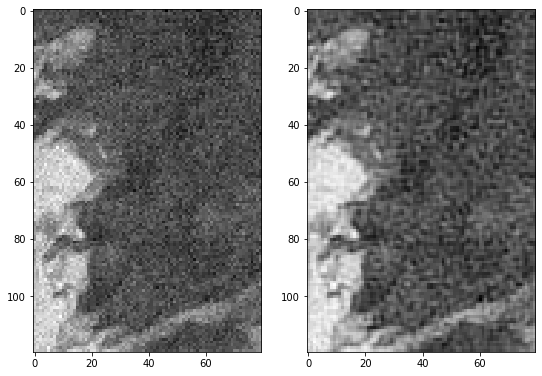

In [16]:
#max_iter = 10
#itr = 0

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 7))
to_img  = transforms.ToPILImage()


for i in range(len(result_img)):
    nosied_image = test_noised[i].cpu().detach().numpy()
    image = result_img[i].cpu().detach().numpy()

    #nosied_image = to_img(nosied_image)
    #image = to_img(image)
    
    ax[0].imshow(nosied_image, cmap='gray')
    ax[1].imshow(image, cmap='gray')

    fig.show()
    #fig.canvas.draw()
    
    #itr += 1
    #if max_iter <= itr:
        #break;

In [21]:
submit_file = result_img.cpu().unsqueeze(1).detach().numpy()
print(submit_file.shape)
np.save('김정민20141445.npy', submit_file)

(400, 1, 120, 80)
